In [1]:
cd ..

/Users/anindya/personal/PremSQL/v2_agent/premsql


/Users/anindya/Library/Caches/pypoetry/virtualenvs/text2sql-jLjiS8B5-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Agents

We are all familiar about agents. Simply we can define agents as an orchestrated workflows between different LLMs. In PremSQL we are bringing the very first versions of Text2SQL agents. Agents in PremSQL are made using the available modular components like generators, executors etc. 

You can even extend agents with your custom logic and workflows with very less number of code using PremSQL. We will explore this in a the coming sections. Agents for Database specific RAGs mainly consist of the following tasks:

1. Executing Queries to databases from natural language contexts (a.k.a Text to SQL).
2. Analysing the table and giving out insights in natural language. 
3. Plotting different graphs to draw out relationship between entities from natural language questions. 
4. A followup which includes error handling of agents and asking followup questions from the user. 

Additionally we maintain a memory that keep tracks of the previous conversation which it uses as context to get the current result. So to summarise, PremSQL has four "routes" that it needs to define before running. Here is a schematic diagram to understand how
PremSQL agents works. 

In [2]:
from IPython.display import HTML
HTML('<img src="../examples/agent_flow.png" width="1000" height="550">')


So in any typical DB based Agentic RAG workflow, the following sequence of event happens:

1. user asks a query. In PremSQL if you want to ask a query for:
    - for Text to SQL, then use `/query`
    - for analysing the output dataframe then use `/analyse` 
    - for plotting something `/plot`
    - anything else goes under `/followup`. If you do not provide these markers, it goes to followup
    route by default. We can also implement an "LLM" based router, but we think it is an overkill. 

2. Once user provides a query specificying the proper routes, it goes to the following set of "Workers". Workers are the specialized components whose job is to complete one specific task. So each worker has some specific set of output schema. You can learn more about different output schema [here](/premsql/agents/models.py)

3. Once the worker processes the input, it provides some output. Then our output parser parses the output and gives back the result to the user. Additionally it updates the memory. 

### Building on top of Workers

So the above workflow is fixed in PremSQL. However you can create your custom Text to SQL / Analyser / Plotter or Followup worker. As long as it adheres with the [output schema](/premsql/agents/models.py), it will be compatible and used with other PremSQL features like Agent Server and Playground. 

### Now Let's watch Agents in action

In [3]:
# Since this demo is done on Mac, so I am using MLX. However same can be done with PremSDK, HF and OpenAI sdk. 

from premsql.agents import BaseLineAgent
from premsql.generators import Text2SQLGeneratorMLX
from premsql.executors import ExecutorUsingLangChain
from premsql.agents.tools import SimpleMatplotlibTool

/Users/anindya/Library/Caches/pypoetry/virtualenvs/text2sql-jLjiS8B5-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define the generator that will do the Text to SQL task

text2sql_model = Text2SQLGeneratorMLX(
    model_name_or_path="premai-io/prem-1B-SQL", experiment_name="text2sql_model", type="test"
)

analyser_plotter_model = Text2SQLGeneratorMLX(
    model_name_or_path="meta-llama/Llama-3.2-1B-Instruct", experiment_name="analyser_model", type="test",
)

2024-10-28 00:03:38,828 - [GENERATOR] - INFO - Experiment folder found in: experiments/test/text2sql_model
Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 76260.07it/s]
2024-10-28 00:03:40,709 - [GENERATOR] - INFO - Experiment folder found in: experiments/test/analyser_model
Fetching 8 files: 100%|██████████| 8/8 [00:00<00:00, 57952.39it/s]


In [5]:
# Now define your agent
db_connection_uri = (
    "sqlite://///Users/anindya/personal/PremSQL/v2_agent/premsql/codebase_community.sqlite"
)

baseline = BaseLineAgent(
    session_name="local_db_rag",                    # An unique session name must be put
    db_connection_uri=db_connection_uri,            # DB which needs to connect for Text to SQL 
    specialized_model1=text2sql_model,              # This referes to the Text to SQL model
    specialized_model2=analyser_plotter_model,      # This refers to any model other than Text to SQL
    executor=ExecutorUsingLangChain(),              # Which DB executor to use
    auto_filter_tables=False,                       # Whether to filter tables before Text to SQL or not (uses LLM)
    plot_tool=SimpleMatplotlibTool()                # Matplotlib Tool which will be used by plotter worker
)

In [6]:
output = baseline(
    question="/query what all tables are present in the database"
)

2024-10-28 00:03:42,866 - [BASELINE-ROUTER] - INFO - Routing to: query
2024-10-28 00:03:46,238 - [BASELINE-TEXT2SQL-WORKER] - INFO - Taking the following selected table in schema: ['badges', 'comments', 'posts', 'tags', 'users', 'votes']
2024-10-28 00:03:49,252 - [PIPELINE-MEMORY] - INFO - Pushed to the database


In [8]:
output.show_output_dataframe()

,type,name,tbl_name,rootpage,sql
0,table,badges,badges,4,CREATE TABLE badges\n(\n Id INTEGER ...
1,table,comments,comments,5645,CREATE TABLE comments\n(\n Id ...
2,table,postHistory,postHistory,5646,CREATE TABLE postHistory\n(\n Id ...
3,index,sqlite_autoindex_postHistory_1,postHistory,5647,None
4,table,postLinks,postLinks,5648,CREATE TABLE postLinks\n(\n Id I...
5,table,posts,posts,5649,CREATE TABLE posts\n(\n Id ...
6,index,sqlite_autoindex_posts_1,posts,5650,None
7,table,tags,tags,5651,CREATE TABLE tags\n(\n Id INTEGE...
8,table,users,users,5652,CREATE TABLE users\n(\n Id INT...
9,index,sqlite_autoindex_users_1,users,5653,None


In [9]:
analysis = baseline(
    question="/analyse Which tables I should use for understand relation about user votes"
)

2024-10-28 00:04:50,910 - [BASELINE-ROUTER] - INFO - Routing to: analyse
2024-10-28 00:04:56,051 - [PIPELINE-MEMORY] - INFO - Pushed to the database


In [10]:
analysis.analysis

'Use the votes table to understand the relation about user votes.'

In [11]:
output = baseline(
    question="/query show me the first 10 rows in votes"
)

2024-10-28 00:05:45,790 - [BASELINE-ROUTER] - INFO - Routing to: query
2024-10-28 00:05:48,085 - [BASELINE-TEXT2SQL-WORKER] - INFO - Taking the following selected table in schema: ['votes']
2024-10-28 00:05:48,704 - [PIPELINE-MEMORY] - INFO - Pushed to the database


In [12]:
output.show_output_dataframe()

,Id,PostId,VoteTypeId,CreationDate,UserId,BountyAmount
0,1,3,2,2010-07-19,None,None
1,2,2,2,2010-07-19,None,None
2,3,5,2,2010-07-19,None,None
3,4,5,2,2010-07-19,None,None
4,5,3,2,2010-07-19,None,None
5,6,4,2,2010-07-19,None,None
6,7,2,2,2010-07-19,None,None
7,10,3,2,2010-07-19,None,None
8,11,5,2,2010-07-19,None,None
9,12,6,2,2010-07-19,None,None


In [13]:
# You can also see what was the SQL used
output.sql_string

'SELECT * FROM votes LIMIT 10;'

In [16]:
output = baseline("/query what is the max and min value of creation date in votes")

2024-10-28 00:07:39,085 - [BASELINE-ROUTER] - INFO - Routing to: query
2024-10-28 00:07:42,631 - [BASELINE-TEXT2SQL-WORKER] - INFO - Error while selecting table: 'include'
2024-10-28 00:07:42,632 - [BASELINE-TEXT2SQL-WORKER] - INFO - Taking the following selected table in schema: ['votes']
2024-10-28 00:07:43,507 - [PIPELINE-MEMORY] - INFO - Pushed to the database


In [17]:
output.show_output_dataframe()

,max(CreationDate),min(CreationDate)
0,2011-05-01,2010-07-19


In [18]:
output = baseline("/query show me all the rows in votes where creation date was in the month of march 2011")

2024-10-28 00:08:46,680 - [BASELINE-ROUTER] - INFO - Routing to: query
2024-10-28 00:08:48,365 - [BASELINE-TEXT2SQL-WORKER] - INFO - Taking the following selected table in schema: ['votes']
2024-10-28 00:08:49,891 - [PIPELINE-UTILS] - INFO - Truncating output table to first 200 rows only
2024-10-28 00:08:49,893 - [PIPELINE-MEMORY] - INFO - Pushed to the database


In [19]:
output.show_output_dataframe()

,Id,PostId,VoteTypeId,CreationDate,UserId,BountyAmount
0,33262,7672,2,2011-03-01,NaN,NaN
1,33263,7648,2,2011-03-01,NaN,NaN
2,33264,7721,2,2011-03-01,NaN,NaN
3,33265,7674,2,2011-03-01,NaN,NaN
4,33266,7687,2,2011-03-01,NaN,NaN
...,...,...,...,...,...,...
195,33483,1164,2,2011-03-02,NaN,NaN
196,33484,1164,5,2011-03-02,1720.0,NaN
197,33485,5591,2,2011-03-02,NaN,NaN
198,33486,5591,5,2011-03-02,1720.0,NaN


2024-10-28 00:10:06,403 - [BASELINE-ROUTER] - INFO - Routing to: plot
2024-10-28 00:10:06,407 - [PLOT-WORKER] - INFO - Going for generation
2024-10-28 00:10:07,197 - [PLOT-WORKER] - INFO - Plot config: {'x': 'VoteTypeId', 'y': 'CreationDate', 'plot_type': 'scatter'}
2024-10-28 00:10:07,274 - [PLOT-WORKER] - INFO - Done base64 conversion
2024-10-28 00:10:07,276 - [PIPELINE-MEMORY] - INFO - Pushed to the database


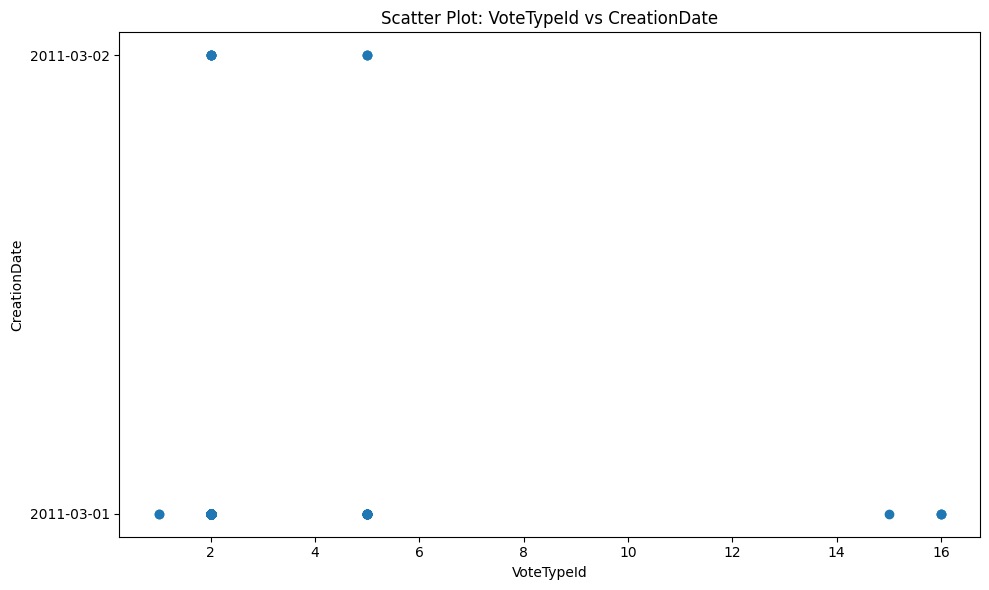

In [21]:
# Now let's plot a time series between creation date and vote type id

plot = baseline(question="/plot a relation between vote type and creation date in scatter")

Super cool right? Remmember, all of these things are done locally in a single MacBook M3 Pro. We are loading two 1B parameter model and seeing the magic at the same levels of GPT-3.5 and so on. However PremSQL also supports closed models too. So if your data is not sensitive then you can surely go for those models as well. 

### Customization over PremSQL Agents

You can customize lot of things in PremSQL. For starters, you can put any type of generators in PremSQL. Here we are
using MLX. You can use huggingface or Prem AI SDK (which provides different models) or other APIs as well. You can also build your own worker from scratch. As you have seen here, that we are using MatplotLib tool, you can also make your seaboarn / Plotly tool for the same thing for more interactive visualization. 

You can put as many number of arguments in your custom agent constructors and workers. As long as it adheres with the output schema, you can enjoy other functionalities like AgentServer and Playground. 

### A note about PremSQL Memory, Router and other limitations:

Since this is the first version, where we are introducing agents and it's capabilities, so it comes with certain limitations as follows:

1. Abscence of a Planner. In other words, we do not support "multi-agent" workflows. For example, after connecting to the database, if you directly ask something complex to plot, as of now, it will not able to plot things. In ideal case, it should "plan" what all things it needs to query, and then which columns needs to be used for plotting. However we are going to support multi-agent framework in coming versions. PRs are welcomed.

2. Context handling in memory. Memory has also a very simple implementation. When you instantiate an agent to work with some "session_name" then it captures all the history and saves it inside a local "sqlite" database in the name of "premsql_pipeline_memory.db" (However you can change the path and name of the db). However, if you want to "analyse" or "plot" something over your previous output, the way it works is, it searches for the latest output dataframe and take that as an input and then output the plot or analysis. As of now, it can not understand history in a semantic sense. 